In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
STOCK = "AAPL"

# DATA

In [ ]:
# download data from yahoo finance
df = yf.download(STOCK, start="2000-01-01", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844981,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.773741,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.785063,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.717125,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.751094,460734400


In [ ]:
df.shape

(6037, 6)

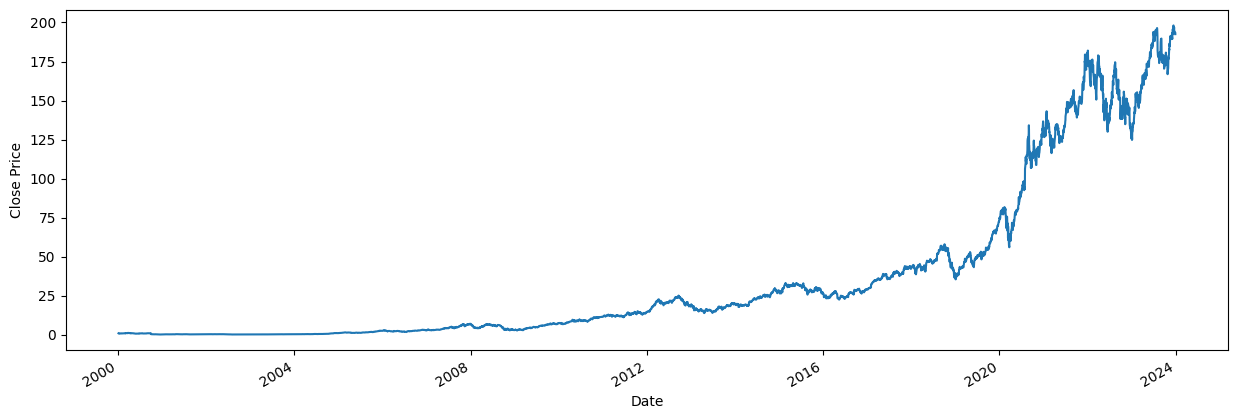

In [ ]:
plt.figure(figsize=(15,5))
df['Close'].plot()
plt.ylabel('Close Price')
plt.show()

## EXPONENTIAL SMOOTHING

In [ ]:
alpha = 0.1

In [ ]:
# Initialize the 'Smooth' column with NaN values
df['Smooth'] = np.nan

df['Smooth']

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
              ..
2023-12-22   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
2023-12-29   NaN
Name: Smooth, Length: 6037, dtype: float64

In [ ]:
df.iloc[0, df.columns.get_loc('Smooth')] = df.iloc[0, df.columns.get_loc('Close')]

for i in range(1, df.shape[0]):
    df.iloc[i, df.columns.get_loc('Smooth')] = alpha * df.iloc[i-1, df.columns.get_loc('Close')] + (1 - alpha) * df.iloc[i-1, df.columns.get_loc('Smooth')]

In [ ]:
df['Smooth'][:6]

Date
2000-01-03    0.999442
2000-01-04    0.999442
2000-01-05    0.991016
2000-01-06    0.984771
2000-01-07    0.971115
2000-01-10    0.962843
Name: Smooth, dtype: float64

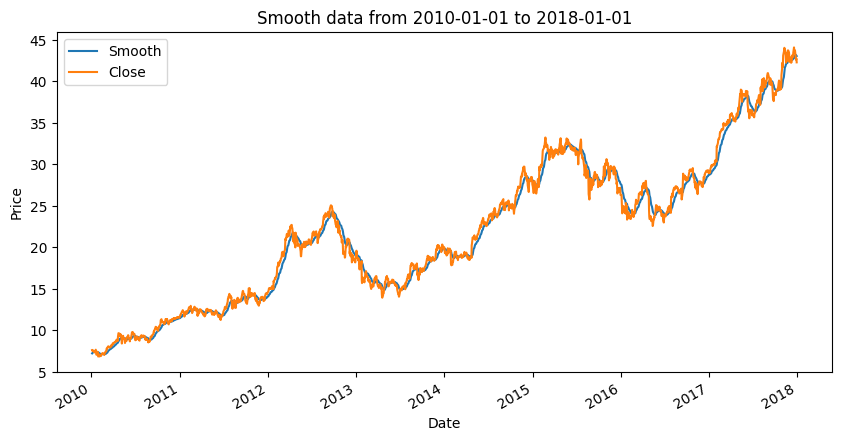

In [ ]:
plt.figure(figsize=(10,5))
df.loc["2010-01-01":"2018-01-01", ['Smooth']].plot(ax=plt.gca())
df.loc["2010-01-01":"2018-01-01", ['Close']].plot(ax=plt.gca())
plt.title("Smooth data from 2010-01-01 to 2018-01-01")
plt.ylabel("Price")
plt.show()

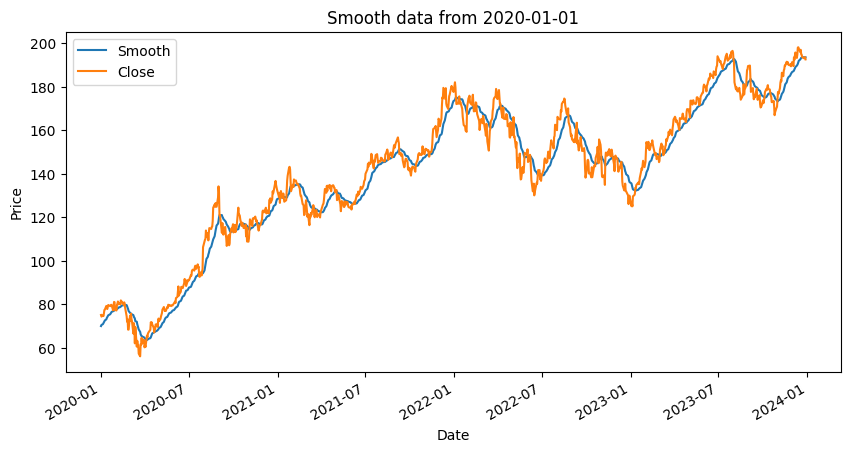

In [ ]:
plt.figure(figsize=(10,5))
df.loc["2020-01-01":, ['Smooth']].plot(ax=plt.gca())
df.loc["2020-01-01":, ['Close']].plot(ax=plt.gca())
plt.title("Smooth data from 2020-01-01")
plt.ylabel("Price")
plt.show()

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Smooth
Date,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844981,535796800,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.773741,512377600,0.999442
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.785063,778321600,0.991016
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.717125,767972800,0.984771
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.751094,460734400,0.971115


## TECHNICAL INDICATORS


RELATIVE STRENGTH INDEX (RSI)

It assesses the overbought and oversold conditions in stock prices by analyzing the degree of recent price changes. The RSI compares the average gains and losses of a stock over a set period, usually 14 trading days. The RSI value ranges from 0 to 100, with readings above 70 typically signaling that a stock is overbought, and readings below 30 indicating that it is oversold. In this study, a 27-day period is used to determine the initial RSI value. The RSI is calculated using the following formula:


$RSI = 100 - \dfrac{100}{1+RS}$


$RS = \dfrac{Average(gain)}{Average(loss)}$

RSI stands for relative strength index, and RS stands for relative strength.


In [ ]:
def RSI(series):
    delta = series.diff()
    up = delta.clip(lower = 0)
    down = -1.0*delta.clip(upper = 0)

    ema_up = up.ewm(com = 26, adjust = False).mean()
    ema_down = down.ewm(com = 26, adjust = False).mean()

    rs = ema_up / ema_down
    rsi = 100 - (100 / (1+rs))
    return rsi

In [ ]:
df['RSI'] = RSI(df['Smooth'])

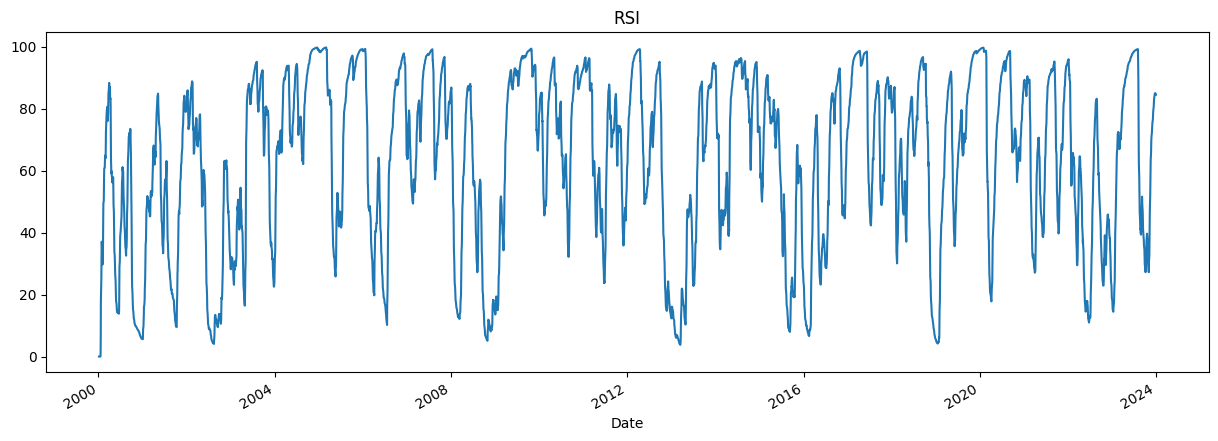

In [ ]:
plt.figure(figsize=(15,5))
df['RSI'].plot()
plt.title("RSI")
plt.show()

MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)

The moving average convergence divergence (MACD) is a trend-following momentum indicator designed to help investors determine if the bearish or bullish momentum in prices is strengthening or weakening.

It is calculated by subtracting the 26-day exponential moving average (the longer moving average) from the 12-day exponential moving average (the shorter moving average) of a security’s prices. The resulting line is known as the MACD line. Additionally, the 9-day exponential moving average of the MACD line, referred to as the signal line, can serve as a trigger for buy and sell signals. A buy signal is indicated when the MACD line is above the signal line, while a sell signal is indicated when it is below the signal line.

The formula for calculating MACD is as follows:

$MACD = EMA_{12}(Price) - EMA_{26}(Price)$

$SL = EMA_9(MACD)$

MACD stands for moving average convergence divergence or MACD line and SL stands for the signal line.

$EMA_n$= n-day exponential moving average

In [ ]:
def MACD(series):
    ema_12 = series.ewm(span = 12).mean()
    ema_26 = series.ewm(span = 26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span = 9).mean()
    return macd, signal

In [ ]:
df['MACD'] = MACD(df['Smooth'])[0] - MACD(df['Smooth'])[1]

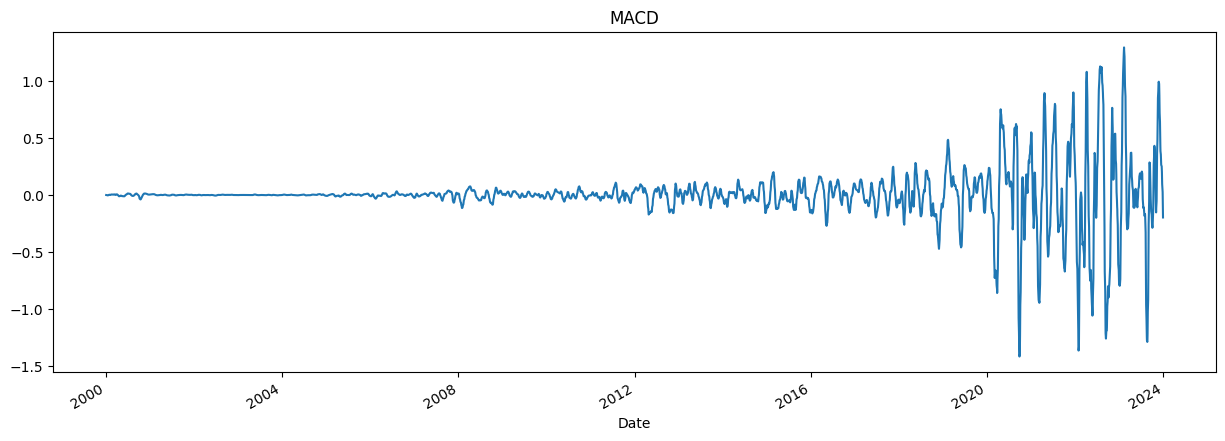

In [ ]:
plt.figure(figsize=(15,5))
df['MACD'].plot(ax=plt.gca())
plt.title("MACD")
plt.show()

PRICE RATE OF CHANGE (ROC)

The price rate of change (ROC) is another momentum oscillator that calculates the percent change in price between the current price and the price from n periods ago. In other words, ROC measures the difference between the current price and the closing price n days ago. It oscillates between positive and negative values, fluctuating above and below the zero line. This oscillator can be used to identify overbought and oversold conditions, divergences, and zero-line crossovers.

We use a 21-day time frame to calculate the initial value of the ROC. The formula for calculating ROC is as follows:

$ROC = \dfrac{Price_t(smooth) - C_{t-21}(smooth}{C_{t-21}(smooth)} .100$

where,

ROC stands for price rate of change at time t;

$Price_t$ = closing price at time t;

$Price_{t−21}$ = closing price 21 periods ago

In [ ]:
def ROC(series):
    return (series - series.shift(21))*100/series.shift(21)

In [ ]:
df['ROC'] = ROC(df['Smooth'])

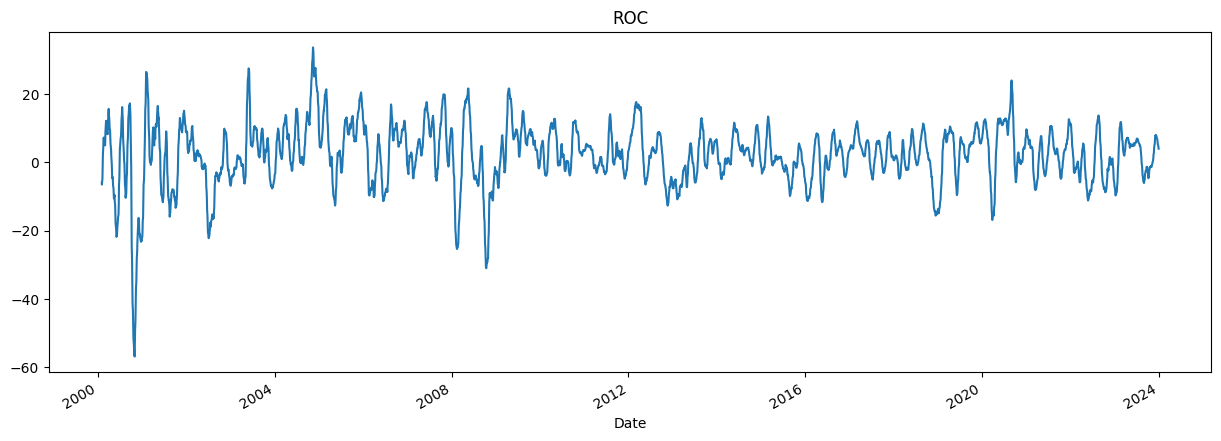

In [ ]:
plt.figure(figsize=(15,5))
df['ROC'].plot()
plt.title("ROC")
plt.show()

STOCHASTIC OSCILLATOR (%K)


The stochastic oscillator, often denoted by the symbol %K, is a momentum oscillator developed by George Lane. It identifies the position of a stock’s closing price relative to the high and low range of the stock’s price over a given period, typically 14 trading days. The stochastic oscillator ranges from 0 to 100, with readings above 80 generally indicating overbought conditions and readings below 20 indicating oversold conditions. We use a 14-day time frame for %K. The formula for calculating the stochastic oscillator is as follows:

$\% K = \dfrac{Price_t - L_{14}}{H_{14} - L_{14}} \times 100$

where,

Price_t = the current closing price.

L14 = lowest price over the past 14 days H14 = highest price in the last 14 days

In [ ]:
def STO_OS(low, high, smooth):
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    return (smooth - low_14)*100/(high_14 - low_14)

In [ ]:
df['%K'] = STO_OS(df['Low'], df['High'], df['Smooth'])

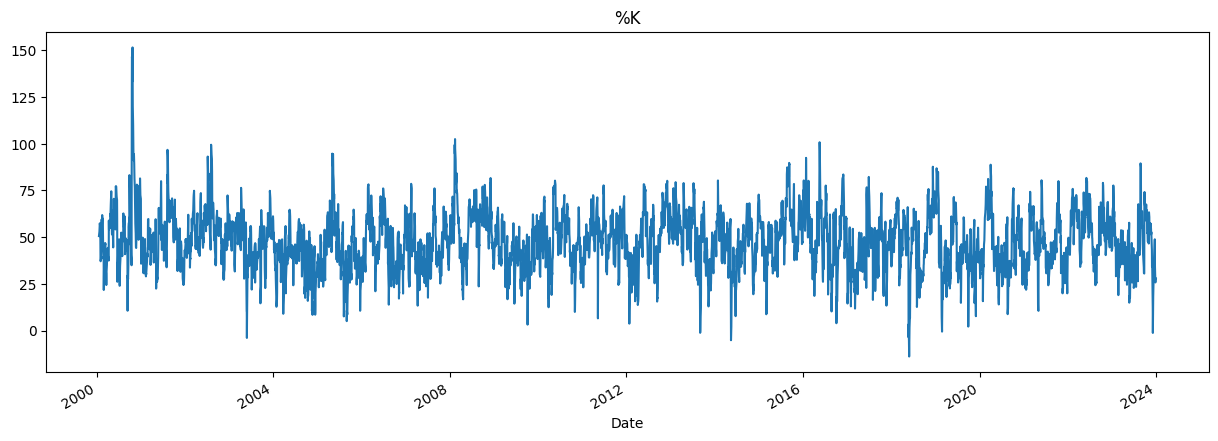

In [ ]:
plt.figure(figsize=(15,5))
df['%K'].plot()
plt.title("%K")
plt.show()

WILLIAMS PERCENTAGE RANGE (WILLIAM %R)


The Williams Percentage Range, commonly known as Williams %R, is a popular indicator developed by Larry Williams. This indicator, often denoted by the symbol %R, measures overbought and oversold levels and operates inversely to %K. While %K ranges between 0 and 100, %R ranges between 0 and -100. A Williams %R below -80 signals a buy, while a Williams %R above -20 signals a sell. We also use a 14-day time frame for %R. The formula for calculating Williams %R is:

$\% R = \dfrac{H_{14} - Price_t}{H_{14} - L_{14}} \times -100$

where,

Price_t = the current closing price

L14 = lowest price over the past 14 days H14 = highest price in the last 14 days


In [ ]:
def WILLIAM(low, high, smooth):
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    return (high_14 - smooth)*-100/(high_14 - low_14)

In [ ]:
df['%R'] = WILLIAM(df['Low'], df['High'], df['Smooth'])

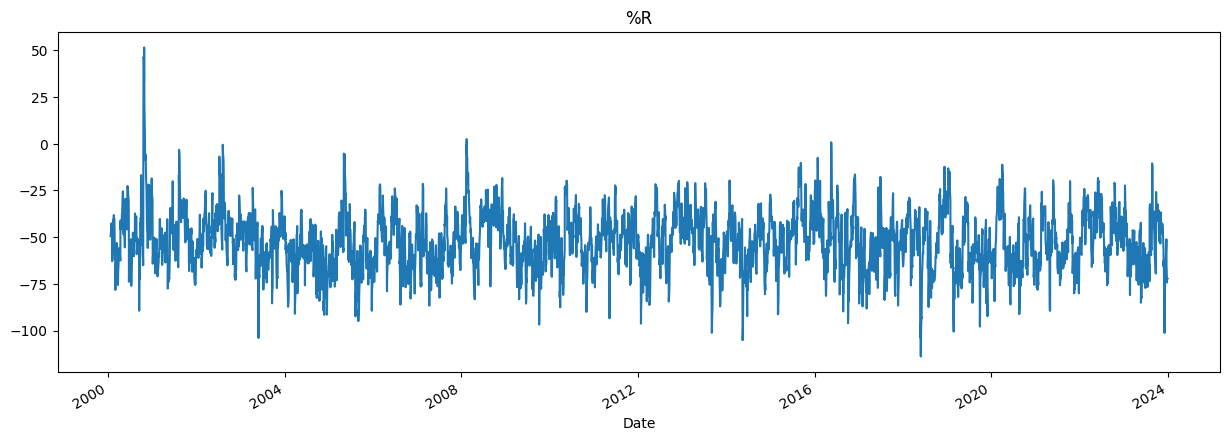

In [ ]:
plt.figure(figsize=(15,5))
df['%R'].plot()
plt.title("%R")
plt.show()

COMMODITY CHANNEL INDEX (CCI)

The Commodity Channel Index (CCI), developed by Donald Lambert, is a valuable oscillator for assessing the direction and strength of a stock price trend. It's also employed to identify overbought and oversold conditions in stock prices. The CCI is calculated by finding the difference between the mean price of a stock and the average of the means, then comparing this difference to the average difference over a period of time, typically 20 days. The CCI is commonly scaled by an inverse factor of 0.015. The formula used to calculate the CCI is as follows:

$CCI = \dfrac{TypicalPrice - MovingAverage_{20}}{0.015 \times  Mean Deviation_20}$

where,
Typical price = average of low, high and close prices: $\sum_{i = 1}^{20}(H+L+Price(smooth))/3$

In [ ]:
def CCI(high, low, smooth):
    typical_price = (high + low + smooth) / 3
    rolling_mean = typical_price.rolling(window=20).mean()
    rolling_std = typical_price.rolling(window=20).std()
    return (typical_price - rolling_mean) / (0.015 * rolling_std)


In [ ]:
df['CCI'] = CCI(df['High'], df['Low'], df['Smooth'])

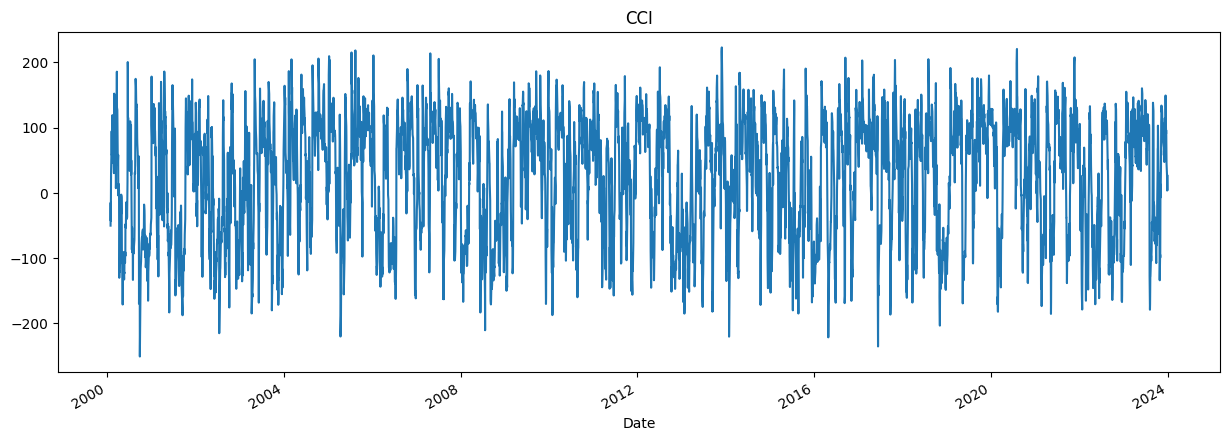

In [ ]:
plt.figure(figsize=(15,5))
df['CCI'].plot()
plt.title("CCI")
plt.show()

DISPARITY INDEX (DIX)

The Disparity Index (DIX), developed by Steve Nison, is a widely used indicator in technical analysis. It's a momentum indicator that compares a stock’s current price with its moving average (MA) over a specific time period. A DIX below 0 indicates that the stock’s current price is below the n-day MA, while a DIX above 0 indicates that the stock’s current price is above the n-day MA. If the DIX equals 0, it indicates that the stock’s current price is equal to the n-day MA. In this paper, a 14-day MA is used. The formula for calculating the DIX with a 14-day MA is as follows:

$DIX = \dfrac{Price_t - MA_{14}}{MA_{14} \times 100}$

where,

Price_t = current stock price.

MA14 = moving average over 14 days

In [ ]:
def DIX(smooth):
    ma_14 = smooth.rolling(window=14).mean()
    return (smooth - ma_14)/(ma_14)

In [ ]:
df['DIX'] = DIX(df['Smooth'])

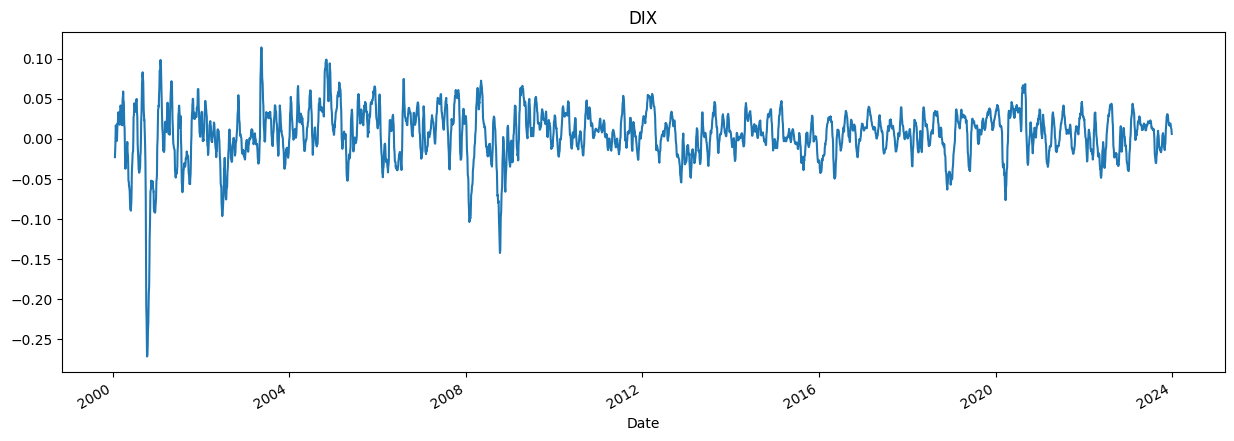

In [ ]:
plt.figure(figsize=(15,5))
df['DIX'].plot()
plt.title("DIX")
plt.show()

## DATA LABELLING

In [ ]:
df['Target_30_smooth'] = np.sign(df['Smooth'].shift(-30) - df['Smooth'])

In [ ]:
df.dropna(axis=0, inplace = True)

In [ ]:
df[100:150]

,Open,High,Low,Close,Adj Close,Volume,Smooth,RSI,MACD,ROC,%K,%R,CCI,DIX,Target_30_smooth
Date,,,,,,,,,,,,,,,
2000-06-26,0.937500,0.977679,0.930804,0.966518,0.817145,185354400,0.876797,30.859492,0.010868,-4.452921,37.002610,-62.997390,114.544013,0.029912,1.0
2000-06-27,0.960379,0.991071,0.921875,0.924107,0.781289,203470400,0.885769,34.244629,0.012042,-1.996030,40.715747,-59.284253,107.395456,0.037329,1.0
2000-06-28,0.952009,0.988839,0.919643,0.972098,0.821863,286428800,0.889603,35.642810,0.012733,-0.106235,42.302368,-57.697632,95.403596,0.038476,1.0
2000-06-29,0.947545,0.963170,0.911830,0.915179,0.773741,203660800,0.897853,38.561996,0.013337,2.066391,45.716461,-54.283539,76.486473,0.043999,-1.0
2000-06-30,0.943080,0.981027,0.922991,0.935268,0.790725,323097600,0.899585,39.163857,0.013408,3.793398,46.433520,-53.566480,82.352641,0.041818,-1.0
2000-07-03,0.930804,0.969866,0.930804,0.952009,0.804879,70828800,0.903154,40.412268,0.013229,5.065165,46.297856,-53.702144,74.376586,0.041148,-1.0
2000-07-05,0.950893,0.985491,0.906250,0.921875,0.779402,265216000,0.908039,42.101577,0.012955,6.042594,48.382353,-51.617647,65.538645,0.041548,-1.0
2000-07-06,0.937500,0.945313,0.886161,0.925223,0.782232,309545600,0.909423,42.580313,0.012385,6.715213,48.850903,-51.149097,33.462395,0.037496,-1.0
2000-07-07,0.939174,0.978795,0.930804,0.972098,0.821863,263603200,0.911003,43.137885,0.011642,7.189348,48.038600,-51.961400,64.769180,0.033425,-1.0


## CORRELATION AMONG FEATURES AND TARGET

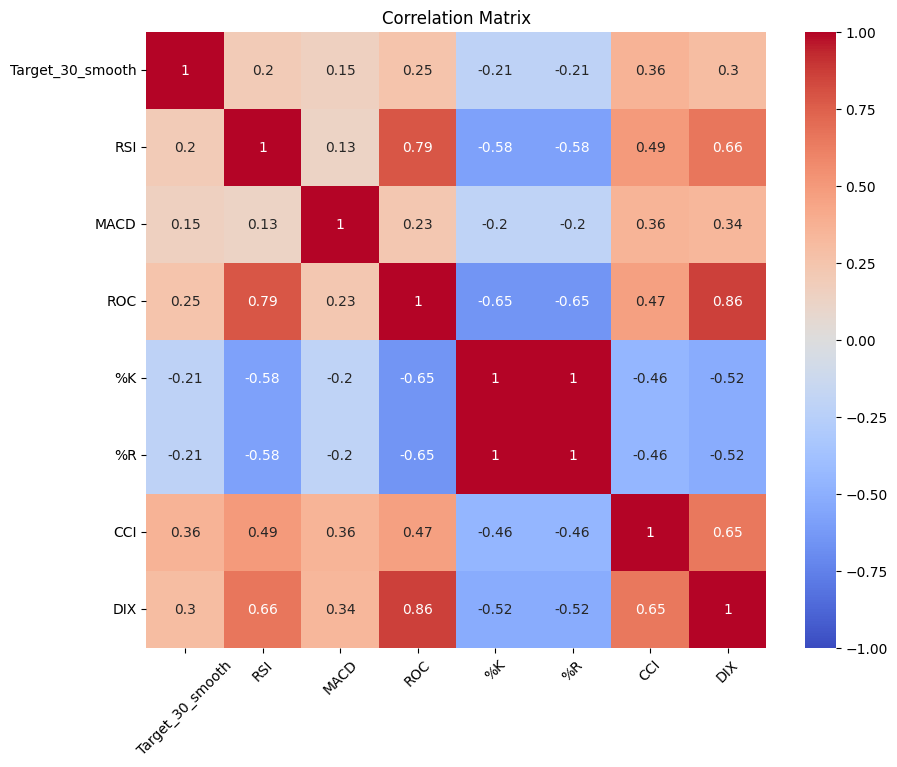

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df[['Target_30_smooth', 'RSI', 'MACD', 'ROC', '%K', '%R', 'CCI', 'DIX']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# df = df.drop('ROC', axis = 1)

In [ ]:
# df = df.drop('%K', axis = 1)

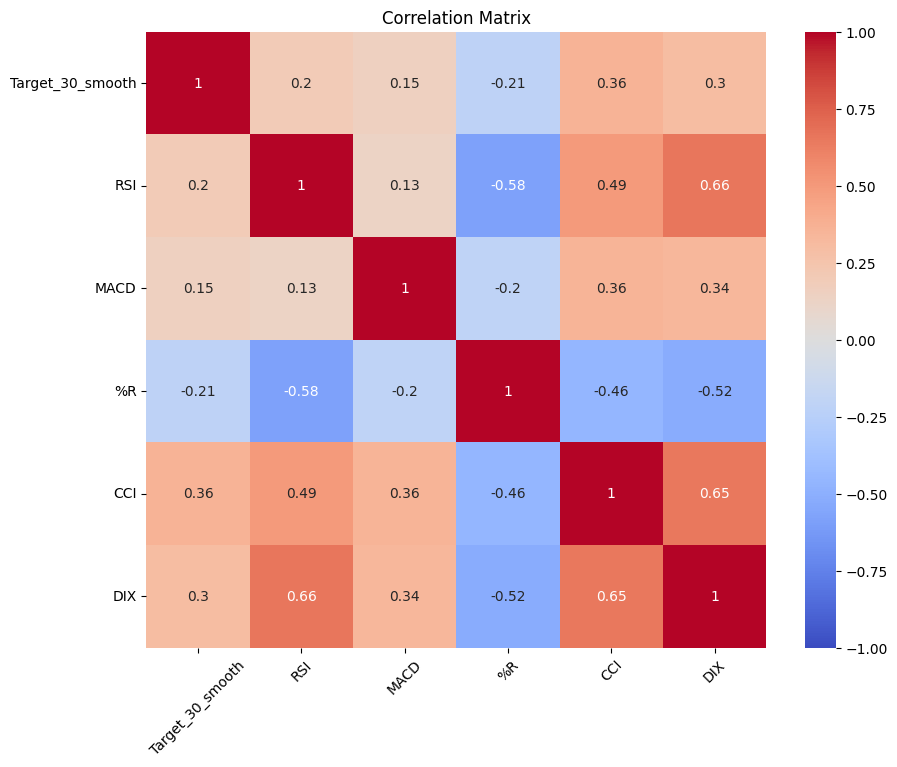

In [ ]:
# Calculate the correlation matrix
correlation_matrix_ = df[['Target_30_smooth', 'RSI', 'MACD', '%R', 'CCI', 'DIX']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
df.loc[:, 'RSI':]

,RSI,MACD,ROC,%K,%R,CCI,DIX,Target_30_smooth
Date,,,,,,,,
2000-02-02,32.225569,0.001779,-5.932041,44.128750,-55.871250,-43.236374,0.006173,1.0
2000-02-03,30.108726,0.001111,-6.511371,37.588351,-62.411649,-15.586928,-0.000740,1.0
2000-02-04,29.691354,0.000602,-5.836864,37.093410,-62.906590,29.448367,-0.003106,1.0
2000-02-07,32.235201,0.000454,-4.923815,38.384091,-61.615909,59.229966,-0.001277,1.0
2000-02-08,38.349647,0.000827,-2.741113,41.791057,-58.208943,89.617944,0.005438,1.0
...,...,...,...,...,...,...,...,...
2023-11-09,44.300827,0.256056,0.093430,56.211205,-43.788795,115.486174,0.007663,1.0
2023-11-10,47.410159,0.367059,0.231969,52.669209,-47.330791,133.764728,0.011209,1.0
2023-11-13,51.685525,0.487990,0.530238,57.320942,-42.679058,123.686576,0.016126,1.0


# TRAIN

## TRAIN TEST SPLIT CASE PREDICTING



In [ ]:
X = df.loc[:, 'RSI':'DIX']
y = df.loc[:, 'Target_30_smooth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

PROPORTION OF UP AND DOWN DAYS IN TRAINING SET

In [ ]:
value_counts = pd.Series(y_train).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_train)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_train)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.6514202172096909
Proportion of -1s: 0.3485797827903091


PROPORTION OF UP AND DOWN DAYS IN TESTING SET

In [ ]:
value_counts = pd.Series(y_test).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_test)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_test)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.6786310517529215
Proportion of -1s: 0.32136894824707846


In [ ]:
grid_rf = {
'n_estimators': [75, 100, 150, 200],
'max_depth': [2, 5, 7, 9, None],
'max_features': [2, 3, 4]
}

cv = KFold(n_splits=4, shuffle=False)
gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
gscv_fit = gscv.fit(X_train, y_train)
best_parameters = gscv_fit.best_params_
print("Hyperparameter: ", best_parameters)

model = RandomForestClassifier(**best_parameters, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Hyperparameter:  {'max_depth': None, 'max_features': 4, 'n_estimators': 100}


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion_mat = confusion_matrix(y_test, y_pred)

In [ ]:
print("TARGET 30 DAYS")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

TARGET 30 DAYS
Accuracy: 0.8472454090150251
Precision: 0.8296361218568666
Recall: 0.8136147984856472
F1 Score: 0.8206943255120093
Confusion Matrix:
[[277 108]
 [ 75 738]]


## UNSHUFFLED TRAINING SET AND TEST SET CASE

In [ ]:
x_train = df.loc[:'2020-01-01', 'RSI':'DIX']
y_train = df.loc[:'2020-01-01', 'Target_30_smooth']

PROPORTION OF UP AND DOWN DAYS IN TRAINING SET

In [ ]:
value_counts = y_train.value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_train)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_train)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.6652694610778443
Proportion of -1s: 0.3347305389221557


In [ ]:
x_train

,RSI,MACD,ROC,%K,%R,CCI,DIX
Date,,,,,,,
2000-02-02,32.225569,0.001779,-5.932041,44.128750,-55.871250,-43.236374,0.006173
2000-02-03,30.108726,0.001111,-6.511371,37.588351,-62.411649,-15.586928,-0.000740
2000-02-04,29.691354,0.000602,-5.836864,37.093410,-62.906590,29.448367,-0.003106
2000-02-07,32.235201,0.000454,-4.923815,38.384091,-61.615909,59.229966,-0.001277
2000-02-08,38.349647,0.000827,-2.741113,41.791057,-58.208943,89.617944,0.005438
...,...,...,...,...,...,...,...
2019-12-24,98.703821,-0.000434,5.899689,45.918111,-54.081889,112.871941,0.024774
2019-12-26,98.765583,0.015126,6.172665,36.425656,-63.574344,120.903017,0.025507
2019-12-27,98.845358,0.036025,6.446783,36.884804,-63.115196,127.091438,0.027600


In [ ]:
grid_rf = {
'n_estimators': [75, 100, 150, 200],
'max_depth': [2, 5, 7, 9, None],
'max_features': [2, 3, 4]
}

cv = KFold(n_splits=4, shuffle=False)
gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
gscv_fit = gscv.fit(x_train, y_train)
best_parameters = gscv_fit.best_params_
print("Hyperparameter: ", best_parameters)

model = RandomForestClassifier(**best_parameters, random_state = 42)
model.fit(x_train, y_train)

Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 150}


RandomForestClassifier(max_depth=2, max_features=4, n_estimators=150,
                       random_state=42)

### MODEL TESTING FROM 2020-01-01


In [ ]:
y_pred = model.predict(df.loc['2020-01-01':, 'RSI':'DIX'].values)
y_test = df.loc['2020-01-01':, 'Target_30_smooth'].values

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


PROPORTION OF UP AND DOWN DAYS IN TESTING SET

In [ ]:
value_counts = pd.Series(y_test).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_test)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_test)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.6137295081967213
Proportion of -1s: 0.3862704918032787


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion_mat = confusion_matrix(y_test, y_pred)

In [ ]:
print("TARGET 30 DAYS FROM 2020-06-01")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

TARGET 30 DAYS FROM 2020-06-01
Accuracy: 0.6075819672131147
Precision: 0.5502251985302833
Recall: 0.5225176354932846
F1 Score: 0.4816968587730427
Confusion Matrix:
[[ 56 321]
 [ 62 537]]


## K-FOLDS CROSS-VALIDATION

In [ ]:
X = df.loc[:, 'RSI':'DIX'].values
y = df.loc[:, 'Target_30_smooth'].values

In [ ]:
folds = 5

In [ ]:
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
models = []
scores = []

In [ ]:
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    value_counts_train = pd.Series(y_train).value_counts()

    # Get proportion of 1s and -1s in training set
    proportion_1_train = value_counts_train.get(1, 0) / len(y_train)
    proportion_minus_1_train = value_counts_train.get(-1, 0) / len(y_train)

    print(proportion_1_train) # Proportion of 1s of Target_30_smooth in training set
    print(proportion_minus_1_train) # Proportion of -1s of Target_30_smooth in test set

    value_counts_test = pd.Series(y_test).value_counts()

    # Get proportion of 1s and -1s in testing set
    proportion_1_test = value_counts_test.get(1, 0) / len(y_test)
    proportion_minus_1_test = value_counts_test.get(-1, 0) / len(y_test)

    print(proportion_1_test)  # Proportion of 1s of Target_30_smooth in test set
    print(proportion_minus_1_test) # Proportion of -1s of Target_30_smooth in test set

    grid_rf = {
    'n_estimators': [75, 100, 150, 200],
    'max_depth': [2, 5, 7, 9, None],
    'max_features': [2, 3, 4]
    }

    cv = KFold(n_splits=4, shuffle=False)
    gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train)
    best_parameters = gscv_fit.best_params_
    for para in best_parameters:
      print(f"{para}: {best_parameters[para]}")

    model = RandomForestClassifier(**best_parameters, random_state = 42)
    model.fit(X_train, y_train)

    models.append(model)

    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    print(training_error) # Training error

    y_pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    scores.append(score)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    print(accuracy)
    print(precision)
    print(recall)
    print(f1)
    print(cm[1, 1])  # True Positive
    print(cm[0, 1]) # False Positive
    print(cm[1, 0]) # False Negative
    print(cm[0, 0]) # True Negative
    print("")

Proportion of 1s of Target_30_smooth in training set: 0.668546365914787
Proportion of -1s of Target_30_smooth in training set: 0.33145363408521306
Proportion of 1s of Target_30_smooth in testing set: 0.6101836393989983
Proportion of -1s of Target_30_smooth in testing set: 0.38981636060100167
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 75}
Training error: 0.2898913951545531
TARGET 30 DAYS
Accuracy: 0.6861435726210351
Precision: 0.68896842756457
Recall: 0.6252705952656448
F1 Score: 0.6212138030319848
Confusion Matrix:
[[163 304]
 [ 72 659]]
Proportion of 1s of Target_30_smooth in training set: 0.6523282522447275
Proportion of -1s of Target_30_smooth in training set: 0.3476717477552725
Proportion of 1s of Target_30_smooth in testing set: 0.6750208855472013
Proportion of -1s of Target_30_smooth in testing set: 0.32497911445279865
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 150}
Training error: 0.3013155147212362
TARGET 30 DAYS
Accuracy: 0.7

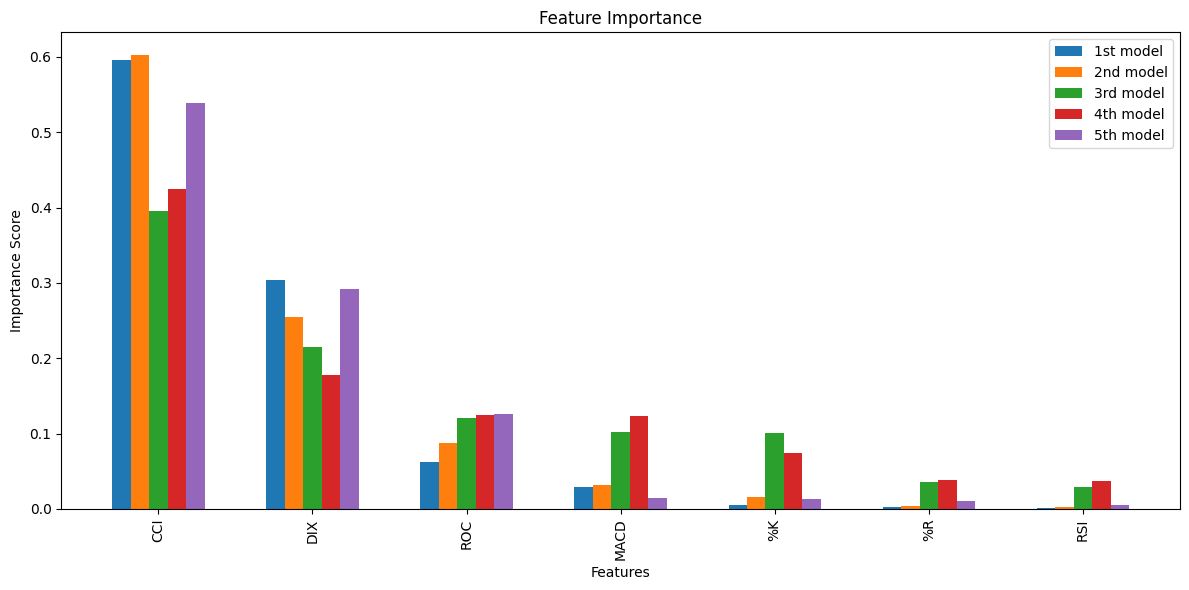

In [ ]:
model_names = ['1st model', '2nd model', '3rd model', '4th model', '5th model']

feature_importances = []
for model in models:
    importance = model.feature_importances_
    feature_importances.append(importance)

num_features = len(x_train.columns)
bar_width = 0.12
index = np.arange(num_features)
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# Plotting the feature importance
plt.figure(figsize=(12, 6))

for i, feature_importance in enumerate(feature_importances):
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_features = x_train.columns[sorted_indices]

    plt.bar(index + i * bar_width, sorted_importance, bar_width, align='center', color=colors[i], label=model_names[i])

plt.xticks(index+bar_width*2, sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()


## ROLLING CROSS-VALIDATION

In [ ]:
folds = 5

In [ ]:
tscv = TimeSeriesSplit(n_splits=folds)
models_ts = []
score_ts = []
train_ts = []

In [ ]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(len(X_train))

    value_counts_train = pd.Series(y_train).value_counts()

    # Get proportion of 1s and -1s in training set
    proportion_1_train = value_counts_train.get(1, 0) / len(y_train)
    proportion_minus_1_train = value_counts_train.get(-1, 0) / len(y_train)

    print(proportion_1_train) # Proportion of 1s of Target_30_smooth in training set
    print(proportion_minus_1_train) # Proportion of -1s of Target_30_smooth in test set

    value_counts_test = pd.Series(y_test).value_counts()

    # Get proportion of 1s and -1s in testing set
    proportion_1_test = value_counts_test.get(1, 0) / len(y_test)
    proportion_minus_1_test = value_counts_test.get(-1, 0) / len(y_test)

    print(proportion_1_test)  # Proportion of 1s of Target_30_smooth in test set
    print(proportion_minus_1_test) # Proportion of -1s of Target_30_smooth in test set

    grid_rf = {
    'n_estimators': [75, 100, 150, 200],
    'max_depth': [2, 5, 7, 9, None],
    'max_features': [2, 3, 4]
    }

    cv = KFold(n_splits=4, shuffle=False)
    gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train)
    best_parameters = gscv_fit.best_params_
    for para in best_parameters:
      print(f"{para}: {best_parameters[para]}")

    model = RandomForestClassifier(**best_parameters, random_state = 42)
    model.fit(X_train, y_train)

    models_ts.append(model)

    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    print(training_error) # Training error

    y_pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    score_ts.append(score)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    print(accuracy)
    print(precision)
    print(recall)
    print(f1)
    print(cm[1, 1])  # True Positive
    print(cm[0, 1]) # False Positive
    print(cm[1, 0]) # False Negative
    print(cm[0, 0]) # True Negative
    print("")

1001
Proportion of 1s of Target_30_smooth in training set: 0.5474525474525475
Proportion of -1s of Target_30_smooth in training set: 0.45254745254745254
Proportion of 1s of Target_30_smooth in testing set: 0.7743229689067201
Proportion of -1s of Target_30_smooth in testing set: 0.22567703109327983
Hyperparameter:  {'max_depth': 2, 'max_features': 2, 'n_estimators': 200}
Training error: 0.3356643356643356
Training error: 0.3356643356643356
TARGET 30 DAYS
Accuracy: 0.7683049147442327
Precision: 0.6471036839473245
Recall: 0.6016090961427749
F1 Score: 0.6126592497288025
Confusion Matrix:
[[ 67 158]
 [ 73 699]]
1998
Proportion of 1s of Target_30_smooth in training set: 0.6606606606606606
Proportion of -1s of Target_30_smooth in training set: 0.33933933933933935
Proportion of 1s of Target_30_smooth in testing set: 0.6800401203610833
Proportion of -1s of Target_30_smooth in testing set: 0.31995987963891676
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 75}
Training error

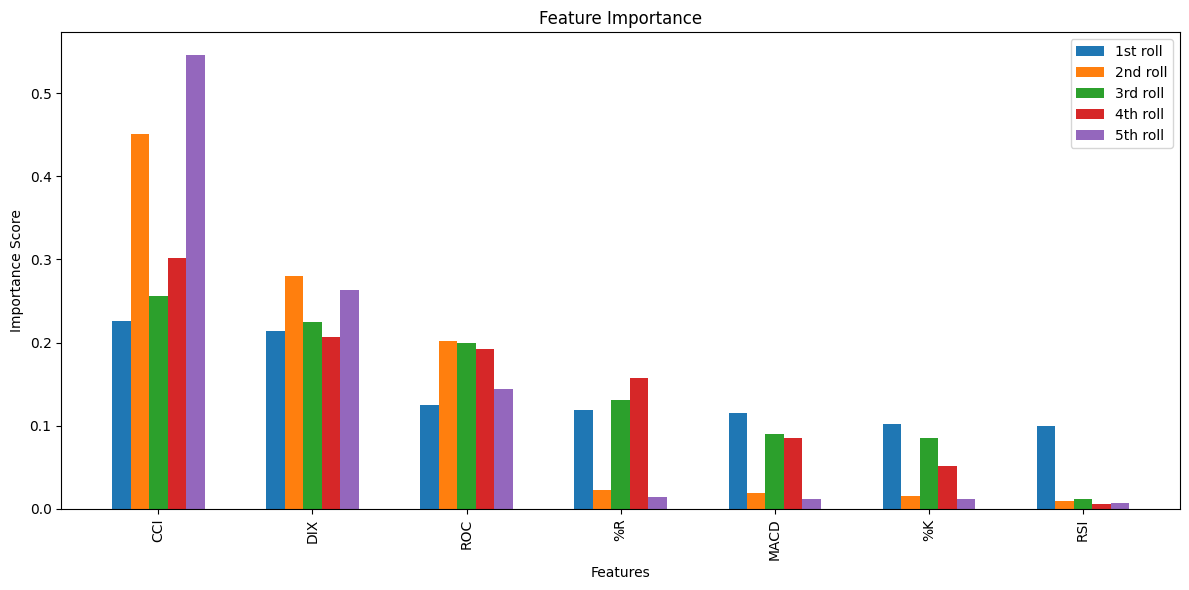

In [ ]:
model_names = ['1st roll', '2nd roll', '3rd roll', '4th roll', '5th roll']

feature_importances = []
for model in models_ts:
    importance = model.feature_importances_
    feature_importances.append(importance)

num_features = len(x_train.columns)
bar_width = 0.12
index = np.arange(num_features)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plotting the feature importance
plt.figure(figsize=(12, 6))

for i, feature_importance in enumerate(feature_importances):
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_features = x_train.columns[sorted_indices]

    plt.bar(index + i * bar_width, sorted_importance, bar_width, align='center', color=colors[i], label=model_names[i])

plt.xticks(index+bar_width*2, sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()